# Satellite Aerosol Monitoring - Quality Assessment for Particulate Matter in Highly Polluted Areas of Europe
&nbsp;

Production date: 30-09-2024

Produced by: Consiglio Nazionale delle Ricerche (CNR)

## 🌍 Use Case: Monitoring particulate matter in highly polluted areas in Europe
## ❓ Quality assessment question
**• Can satellite data capture the aerosol seasonal variability in the most polluted areas of Europe?**

Despite improvements, air pollution is still a major health concern for Europeans. In 2019, air pollution continued to drive a significant burden of premature death and disease in Europe [1],[2]. In central and eastern Europe, the burning of solid fuels for domestic heating and their use in industry results in the highest concentrations of particulate matter [3]. Although the trend of aerosol optical depth (AOD) over Europe has been well investigated, few studies have focused on fine-mode AOD (fAOD), which is more strongly associated with anthropogenic activities. Understanding changes in fAOD is an important step toward developing measures to mitigate air pollution and global climate change [4]. In 2019, 97% of the urban population was exposed to concentrations of fine particulate matter (PM2.5) above the new WHO guideline level of 5 µg/m3 [1]. Eastern Europe was one of the regions with the highest concentrations of PM2.5. Hence, it is important to study the aerosol seasonal variability in Eastern Europe. 
## 📢 Quality assessment statement

The AOD and fine-mode AOD from the SLSTR sensor on the Sentinel 3 satellite can capture aerosol seasonal variability.
This notebook concludes that the aerosol dataset is able to monitor the most polluted areas of Europe. 

### 📋 Methodology

The analysis comprises the following steps: 

• Data Collection and Preprocessing: Download AOD and Fine_AOD data (AOD550 and FM_AOD550 (Aerosol properties gridded data from 1995 to present derived from satellite observations), horizontal resolution: 1° x 1°; temporal resolution: monthly);

• Compute the seasonal and spatial weighted mean for AOD and fAOD;

• Create the spatial maps of AOD550 and FM_AOD550 over eastern Europe for 2019;

• Calculate the seasonal mean of AOD and fAOD over eastern Europe for the years 2019 and 2020;

• Plot the seasonal mean of AOD and fAOD over eastern Europe for the years 2019 and 2020;

• Calculate the seasonal mean of AOD and fAOD over the east and west of Europe for the year 2019;

• Plot the seasonal mean of AOD and fAOD over the east and west of Europe for the year 2019.

## 📈 Analysis and Results

(template:section-1)=
### 1. Data Collection and Preprocessing
Packages that were requested have been imported. The request was defined, and data was downloaded.
The time dimension of monthly data for 2019 was converted and redefined.

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
from c3s_eqc_automatic_quality_control import diagnostics, download, plot,utils
import warnings
warnings.filterwarnings("ignore")

collection_id = "satellite-aerosol-properties"

year_start = 2019
year_stop = 2019

#east Europe
lon_slice = slice(7.5, 24.4)
lat_slice = slice(43.7, 54.3)

request = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    "version": "v2.1",
}
ds = download.download_and_transform(
    collection_id,
    request,
    split_all=True
)

ds_monthly = ds
ds_monthly["source"] = ds_monthly["source"].str.slice(None, 6)
ds_monthly["source"] = pd.to_datetime(ds_monthly["source"],format="%Y%m")
ds_monthly = ds_monthly.rename({'source': 'time'})
ds_monthly = utils.regionalise(ds_monthly, lon_slice=lon_slice, lat_slice=lat_slice)
#print(ds_monthly)

100%|██████████| 12/12 [00:00<00:00, 27.38it/s]


(template:section-2)=
### 2. Compute the seasonal and spatial weighted mean for AOD and fAOD 

In [3]:
ds_seas=ds_monthly.groupby('time.season').mean() #seasonal mean

def source_to_time_seasonal(ds):
    ds_time = pd.to_datetime(ds["source"].str.slice(None, 6), format="%Y%m").to_period("Q")
    ds = ds.rename({"source": "time"})
    ds["time"] = ds_time.astype(str)  # Convert to string format
    return ds
    
def source_to_time_seasonal_and_spatial_weighted_mean(ds, lon_slice, lat_slice):
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    return diagnostics.spatial_weighted_mean(source_to_time_seasonal(ds))

ds_mean = download.download_and_transform(
    collection_id,
    request,
    transform_func=source_to_time_seasonal_and_spatial_weighted_mean,
    transform_func_kwargs={
        "lon_slice": lon_slice,
        "lat_slice": lat_slice,
    },
    split_all=True
)

print(ds_mean)

100%|██████████| 12/12 [00:01<00:00,  8.77it/s]

<xarray.Dataset> Size: 160B
Dimensions:                      (time: 4)
Coordinates:
  * time                         (time) <U6 96B '2019Q1' '2019Q2' ... '2019Q4'
Data variables:
    AOD550                       (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
    FM_AOD550                    (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
    NMEAS                        (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:              German Aerospace Center, DFD
    geospatial_lat_max:        90.0
    geospatial_lat_min:        -90.0
    geospatial_lon_max:        180.0
    ...                        ...
    sensor:                    SLSTR
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    su

(template:section-3)=
### 3. Create the spatial maps of AOD550 and FM_AOD550 over east Europe for 2019

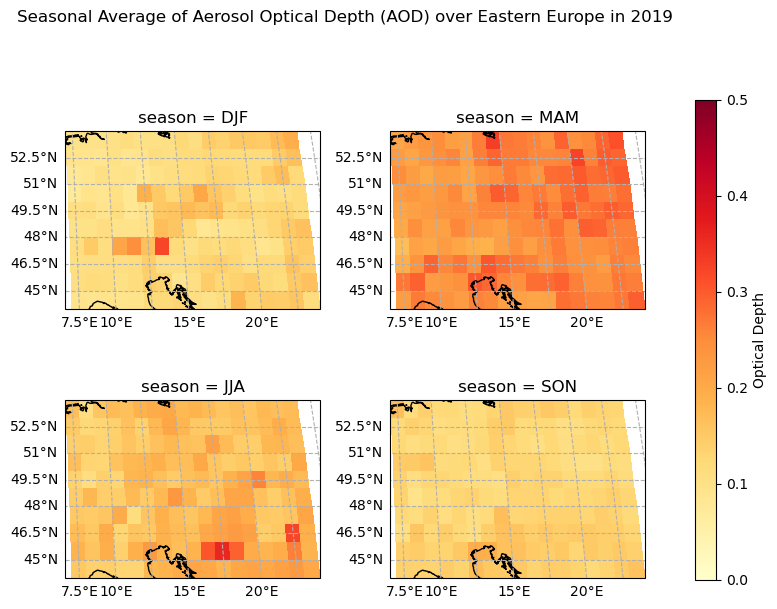

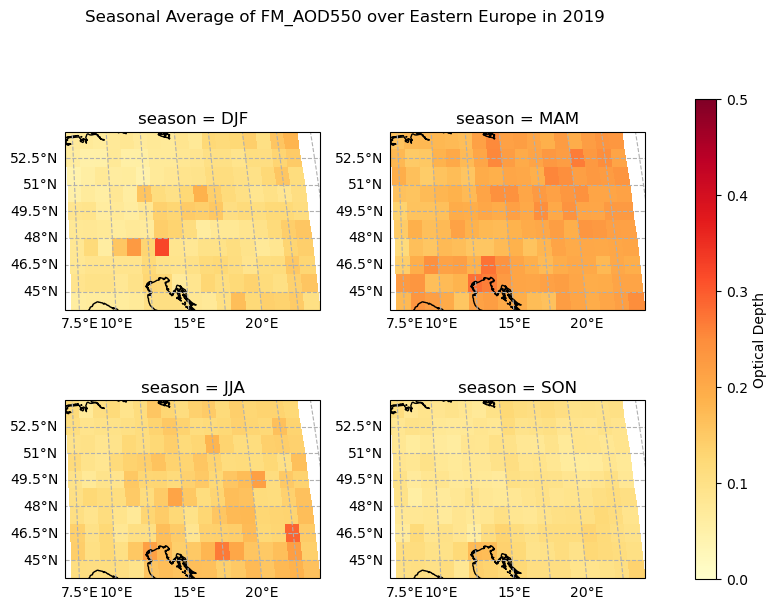

In [4]:
titles = ['season = DJF', 'season = MAM', 'season = JJA', 'season = SON']

map_proj = ccrs.Robinson()

p = ds_seas["AOD550"].plot.pcolormesh(cmap='YlOrRd', vmax=0.5, vmin=0, col="season", col_wrap=2,
                                      transform=ccrs.PlateCarree(),
                                      subplot_kws={"projection": map_proj},
                                      add_colorbar=False)

for ax, title in zip(p.axs.flat, titles):
    ax.coastlines()
    ax.set_title(title)
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

mappable = p.axes[0][0].collections[0]

# Create colorbar
cax = plt.axes([1, 0.1, 0.03, 0.8])
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('Optical Depth')

# Set the main title for the entire figure
plt.suptitle("Seasonal Average of Aerosol Optical Depth (AOD) over Eastern Europe in 2019", y=1.05)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to make space for the main title
plt.show()
########

map_proj = ccrs.Robinson()

p = ds_seas["FM_AOD550"].plot.pcolormesh(cmap='YlOrRd', vmax=0.5, vmin=0, col="season", col_wrap=2,
                                      transform=ccrs.PlateCarree(),
                                      subplot_kws={"projection": map_proj},
                                      add_colorbar=False)

for ax, title in zip(p.axs.flat, titles):
    ax.coastlines()
    ax.set_title(title)
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

mappable = p.axes[0][0].collections[0]

# Create colorbar
cax = plt.axes([1, 0.1, 0.03, 0.8])
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('Optical Depth')

# Set the main title for the entire figure
plt.suptitle("Seasonal Average of FM_AOD550 over Eastern Europe in 2019", y=1.05)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to make space for the main title
plt.show()


(template:section-4)=
### 4. Calculate the seasonal mean of AOD and fAOD over eastern Europe for the years 2019 and 2020.

• Setting up data for AOD and fAOD and downloading the monthly average dataset.

• Convert and redefine the time dimension of monthly data for 2020.

• Combine the two monthly datasets along the version dimension.

• Calculate the dataset average values in each season during 2020 and merge the two versions.

• Setting up data for AOD and fAOD and download the seasonal average dataset over east Europe for 2020.

In [5]:
from c3s_eqc_automatic_quality_control import download

collection_id = "satellite-aerosol-properties"
request2020 = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
}

time_dict = {
    "v2.1": {"start": "2020-01", "stop": "2020-06"},
    "v2.2": {"start": "2020-07", "stop": "2020-12"},
}

lon_slice = slice(7.5, 24.4)
lat_slice = slice(43.7, 54.3)

ds_dict = {}
for version, kwargs in time_dict.items():
    requests = download.update_request_date(
        request2020 | {"version": version}, **kwargs, stringify_dates=True
    )
    ds_dict[version] = download.download_and_transform(
        collection_id, requests, chunks={"year": 1, "month": 1}
    )



ds_monthly_dict = {}
for version, ds in ds_dict.items():
    ds_monthly = ds.copy()
    ds_monthly["source"] = ds_monthly["source"].str.slice(None, 6)
    ds_monthly["source"] = pd.to_datetime(ds_monthly["source"], format="%Y%m")

    ds_monthly = ds_monthly.rename({'source': 'time'})

    ds_monthly = utils.regionalise(ds_monthly, lon_slice=lon_slice, lat_slice=lat_slice)

    ds_monthly_dict[version] = ds_monthly



ds_monthly_merged = xr.concat([ds_monthly_dict['v2.1'],ds_monthly_dict['v2.2']], dim='time')

print(ds_monthly_merged)



ds_seas_mereged = ds_monthly_merged.groupby('time.season').mean()



from c3s_eqc_automatic_quality_control import download

collection_id = "satellite-aerosol-properties"
request2020 = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
}

time_dict = {
    "v2.1": {"start": "2020-01", "stop": "2020-06"},
    "v2.2": {"start": "2020-07", "stop": "2020-12"},
}
lon_slice = slice(7.5, 24.4)
lat_slice = slice(43.7, 54.3)


ds_dict = {}

def custom_transform_func(ds):
    return source_to_time_seasonal_and_spatial_weighted_mean(ds, lon_slice, lat_slice)

for version, kwargs in time_dict.items():
    requests = download.update_request_date(
        request2020 | {"version": version}, **kwargs, stringify_dates=True
    )
    
    # Use the download_and_transform function if available
    ds_chunked = download.download_and_transform(
        collection_id, requests, chunks={"year": 1, "month": 1},
        transform_func=custom_transform_func
    )

    # Cache or use the transformed dataset as needed
    ds_dict[version] = ds_chunked

# Merge the transformed datasets
final_dataset = xr.merge(list(ds_dict.values()))
print(final_dataset)



100%|██████████| 6/6 [00:00<00:00, 46.19it/s]


<xarray.Dataset> Size: 33kB
Dimensions:                      (time: 12, latitude: 10, longitude: 17)
Coordinates:
  * time                         (time) datetime64[ns] 96B 2020-01-01 ... 202...
  * latitude                     (latitude) float32 40B 44.5 45.5 ... 52.5 53.5
  * longitude                    (longitude) float32 68B 7.5 8.5 ... 22.5 23.5
Data variables:
    AOD550                       (time, latitude, longitude) float32 8kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
    FM_AOD550                    (time, latitude, longitude) float32 8kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time, latitude, longitude) float32 8kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
    NMEAS                        (time, latitude, longitude) float32 8kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:         

100%|██████████| 6/6 [00:00<00:00, 27.64it/s]


<xarray.Dataset> Size: 160B
Dimensions:                      (time: 4)
Coordinates:
  * time                         (time) <U6 96B '2020Q1' '2020Q2' ... '2020Q4'
Data variables:
    AOD550                       (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
    FM_AOD550                    (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
    NMEAS                        (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:              German Aerospace Center, DFD
    geospatial_lat_max:        90.0
    geospatial_lat_min:        -90.0
    geospatial_lon_max:        180.0
    ...                        ...
    sensor:                    SLSTR
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    su

(template:section-5)=
### 5. Plot the seasonal mean of AOD and fAOD over eastern Europe for the years 2019 and 2020.

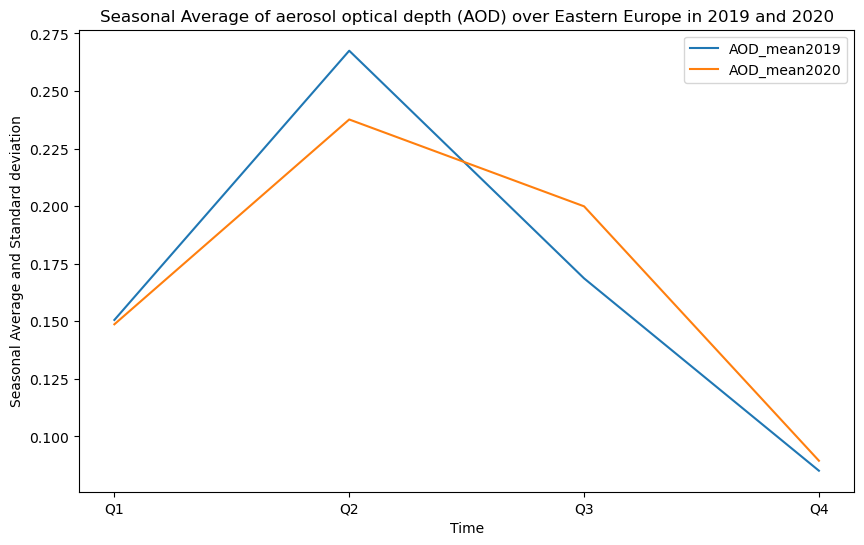

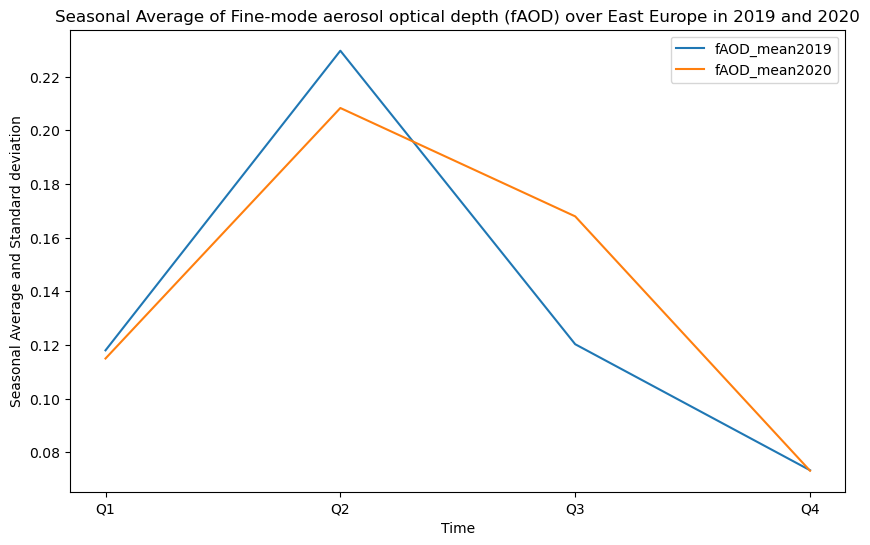

In [6]:
import matplotlib.pyplot as plt
import numpy as np
t = ds_mean["time"] 
# Assuming 't' contains the time values in the format 'YYYYQn'
# Extract the quarters from the coordinates
quarters = np.unique([time[-2:] for time in t.coords['time'].values.astype(str)])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y1 = ds_mean['AOD550']
plt.plot(t, y1, label="AOD_mean2019")

y2 = final_dataset['AOD550']
plt.plot(t, y2, label="AOD_mean2020")

ax.set_xlabel('Time')
ax.set_ylabel('Seasonal Average and Standard deviation')
ax.set_title('Seasonal Average of aerosol optical depth (AOD) over Eastern Europe in 2019 and 2020')
ax.legend()

# Set custom x-axis ticks
plt.xticks(t.values, quarters)
plt.show()
import matplotlib.pyplot as plt
import numpy as np
t = ds_mean["time"] 
# Assuming 't' contains the time values in the format 'YYYYQn'
# Extract the quarters from the coordinates
quarters = np.unique([time[-2:] for time in t.coords['time'].values.astype(str)])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y1 = ds_mean['FM_AOD550']
plt.plot(t, y1, label="fAOD_mean2019")

y2 = final_dataset['FM_AOD550']
plt.plot(t, y2, label="fAOD_mean2020")

ax.set_xlabel('Time')
ax.set_ylabel('Seasonal Average and Standard deviation')
ax.set_title('Seasonal Average of Fine-mode aerosol optical depth (fAOD) over East Europe in 2019 and 2020')
ax.legend()

# Set custom x-axis ticks
plt.xticks(t.values, quarters)

plt.show()

(template:section-6)=
### 6. Calculate the seasonal mean of AOD and fAOD over the east and west of Europe for the year 2019. 

• Define the request for western Europe in 2019.

• Download AOD and fAOD data for western Europe in 2019.

• Convert and redefine the time dimension of monthly data for 2019.

• Calculate the dataset average values in each season during 2019 over west Europe.

• Download seasonal and spatial weighted mean of AOD and fAOD data over wetern Europe.


In [7]:
#Define request
collection_id = "satellite-aerosol-properties"

year_start = 2019
year_stop = 2019

#west Europe
lon_slice = slice(-2.4, 3.5)
lat_slice = slice(44, 49.4)
requestwest = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    "version": "v2.1",
}


dswest = download.download_and_transform(
    collection_id,
    requestwest,
    split_all=True
)


dswest_monthly = dswest
dswest_monthly["source"] = dswest_monthly["source"].str.slice(None, 6)
dswest_monthly["source"] = pd.to_datetime(dswest_monthly["source"],format="%Y%m")
dswest_monthly = dswest_monthly.rename({'source': 'time'})
dswest_monthly = utils.regionalise(dswest_monthly, lon_slice=lon_slice, lat_slice=lat_slice)
#print(ds_monthly)


dswest_seas=dswest_monthly.groupby('time.season').mean() #seasonal mean


dswest_mean = download.download_and_transform(
    collection_id,
    requestwest,
    transform_func=source_to_time_seasonal_and_spatial_weighted_mean,
    transform_func_kwargs={
        "lon_slice": lon_slice,
        "lat_slice": lat_slice,
    },
    split_all=True
)


100%|██████████| 12/12 [00:00<00:00, 22.55it/s]


(template:section-7)=
### 7. Plot the seasonal mean of AOD and fAOD over the east and west of Europe for the year 2019.

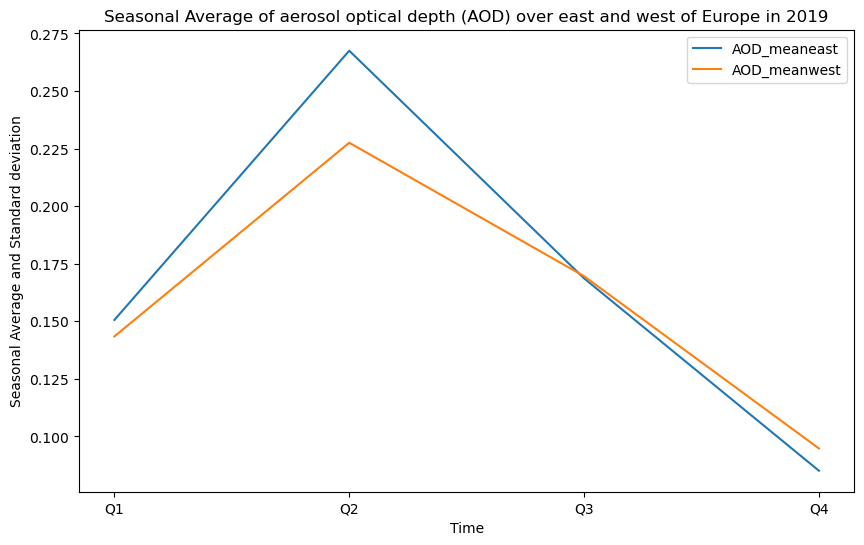

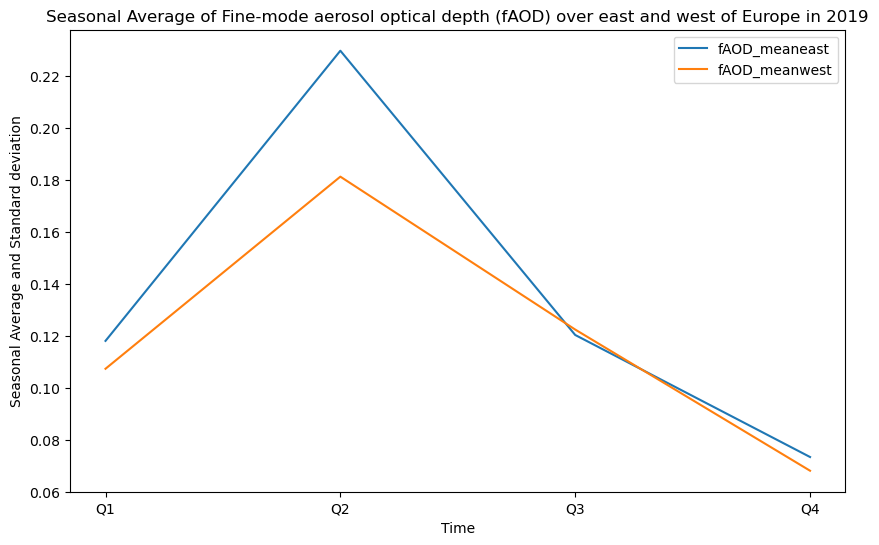

In [9]:
import matplotlib.pyplot as plt
import numpy as np
t = dswest_mean["time"] 


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y1 = ds_mean['AOD550']
plt.plot(t, y1, label="AOD_meaneast")

y2 = dswest_mean['AOD550']
plt.plot(t, y2, label="AOD_meanwest")

ax.set_xlabel('Time')
ax.set_ylabel('Seasonal Average and Standard deviation')
ax.set_title('Seasonal Average of aerosol optical depth (AOD) over east and west of Europe in 2019')
ax.legend()

# Set custom x-axis ticks
plt.xticks(t.values, quarters)

plt.show()


import matplotlib.pyplot as plt
import numpy as np
t = dswest_mean["time"] 


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y1 = ds_mean['FM_AOD550']
plt.plot(t, y1, label="fAOD_meaneast")

y2 = dswest_mean['FM_AOD550']
plt.plot(t, y2, label="fAOD_meanwest")

ax.set_xlabel('Time')
ax.set_ylabel('Seasonal Average and Standard deviation')
ax.set_title('Seasonal Average of Fine-mode aerosol optical depth (fAOD) over east and west of Europe in 2019')
ax.legend()

# Set custom x-axis ticks
plt.xticks(t.values, quarters)

plt.show()

### Main outcome
1. The air pollution was compared for the years 2019 and 2020 by examining the seasonal temporal and spatial variations of the AOD using the AOD product from the SLSTR instrument on board Sentinel-3. AOD concentration in 2019, especially in the summer, is higher than in 2020, which is in accordance with PM10 concentrations reported over Europe within the European Environment Agency's (EEA) report on Europe's air quality status issue in 2021. The report states that PM10 levels increased in Eastern Europe in 2019. Therefore, it can be concluded that AOD and PM10 variability are generally correlated.
2. The comparison of AOD and fAOD seasonal averages in 2019 and 2020 over eastern Europe reveals that the coarse aerosol fraction is dominant in winter and autumn, and this agrees with the increased PM10 concentration compared to PM2.5 over Eastern Europe, as shown in the same report from the EEA.
3. Seasonal averages of AOD and fAOD in 2019 over the east and west of Europe demonstrate that higher AOD and fAOD values are observed over the east compared to the west. 
Also, these results are in accordance with the EEA report, which states that PM2.5 and PM10 levels increased in eastern Europe in 2019.

### References

1. https://www.eea.europa.eu/publications/air-quality-in-europe-2021/air-quality-status-briefing-2021 Report no. 15/2021 Title: Air quality in Europe 2021 HTML - TH-AL-21-014-EN-Q - ISBN 978-92-9480-403-7 - ISSN 1977-8449 - doi: 10.2800/549289
2. Khomenko, S., Cirach, M., Pereira-Barboza, E., Mueller, N., Barrera-Gómez, J., Rojas-Rueda, D., de Hoogh, K., Hoek, G. and Nieuwenhuijsen, M., 2021. Premature mortality due to air pollution in European cities: a health impact assessment. The Lancet Planetary Health, 5(3), pp.e121-e134. (https://www.thelancet.com/journals/lanplh/article/PIIS2542-5196(20)30272-2/fulltext)
3. Knigawka, P., Pianko-Oprych, P., Krpec, K. and Kuboňová, L., 2022. Comparison of emissions from smokeless coal combustion in a household heating boiler used in Central Europe. International Journal of Environmental Science and Technology, 19(8), pp.7151-7164.
4. Yan, X., Zang, Z., Zhao, C. and Husi, L., 2021. Understanding global changes in fine-mode aerosols during 2008–2017 using statistical methods and deep learning approach. Environment International, 149, p.106392.
